In [1]:
import pandas as pd
import numpy as np
from functions import cut_DF, str_to_day, day_to_str, obtain_Features
from construct_DF import construct_DF
from plot_Tempo_Spatio import plot_Tempo_Spatio
from STAR import STAR_analysis
from TCP import TCP_analysis

# Data Preparation

In [2]:
# Inputs


url = "https://query.data.world/s/7ifvvpyy23sa2fciuvcygehakxlnnv" # URL for raw data

COUNTIES = ["San Francisco", "Alameda",  "Contra Costa", "Marin", "Napa", 
            "San Mateo", "Santa Clara", "Solano", "Sonoma"]
COUNTIES.sort()

STATE = "California"

INFO = pd.read_csv("https://raw.githubusercontent.com/PawinData/UC/SFBA/INFO.csv", 
                   index_col=0)  # population and coordinates of populous center of each county

DistanceMatrix = pd.read_csv("https://raw.githubusercontent.com/PawinData/UC/SFBA/DistanceMatrix_shortestnetworks.csv", 
                             index_col=0)  # shortest-network distance between counties

start = "2020-03-01"  # the time window to investigate
end = "2020-03-20"

In [3]:
# construct dataframe

DF = construct_DF(url, STATE, COUNTIES, INFO)   # row = time series for a county
DF = cut_DF(DF, start, end)   # only look at a certain time window
print(DF)

               2020-03-01  2020-03-02  2020-03-03  2020-03-04  2020-03-05  \
Alameda          0.598326    0.000000    0.598326    0.000000    0.000000   
Contra Costa     0.000000    0.000000    0.866907    0.000000    0.000000   
Marin            0.000000    0.000000    0.000000    0.000000    0.000000   
Napa             0.000000    0.000000    0.000000    0.000000    0.000000   
San Francisco    0.000000    0.000000    0.000000    0.000000    2.268734   
San Mateo        0.000000    1.304507    0.000000    0.000000    0.000000   
Santa Clara      1.556136    1.037424    1.037424    1.556136    3.112272   
Solano           2.419292    0.000000    0.000000    0.000000    0.000000   
Sonoma           0.000000    2.066637    0.000000    2.066637    0.000000   

               2020-03-06  2020-03-07  2020-03-08  2020-03-09  2020-03-10  \
Alameda          0.598326    0.000000    0.000000   12.564851    0.598326   
Contra Costa     2.600722    0.000000    4.334536    0.000000    0.000000  

# Verification of Tempo-Spatial Correlation

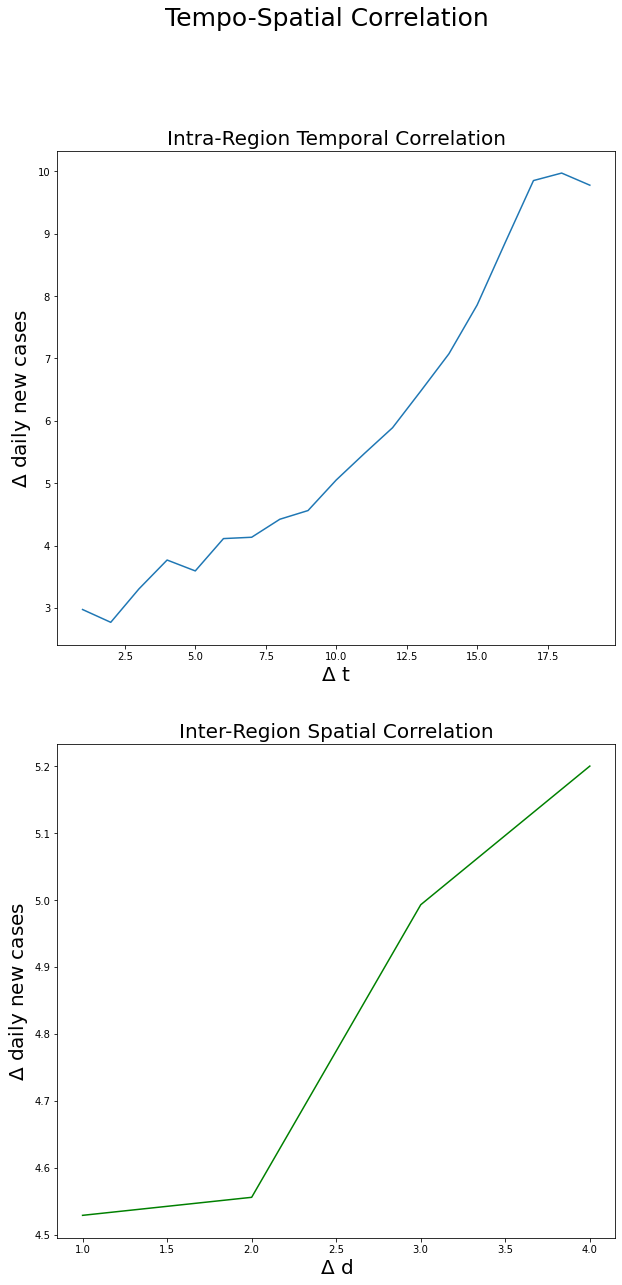

In [4]:
plot_Tempo_Spatio(DF, DistanceMatrix)

# Data Analysis

In [ ]:
# model parameters

h = 1          # controls the degree of spatial correlation
lam = 1        # controls the contribution of temporal correlation
rou = 2        # penality in ADMM algorithm
gamma = 0.1    # learning rate in ADMM algorithm
eps = 10**(-5) # significance level

In [4]:
Y = DF.to_numpy()     # target matrix

D = DistanceMatrix.to_numpy()    # distance matrix

# feature matrices
X = obtain_Features("Features.p", start, end)   # a sequence of M-by-N feature matrices

K,M,N = X.shape
if not (Y.shape==(N,K) and D.shape==(N,N)):
    print("Shapes of matrices are not incompatible.")

17.784054546400508

In [10]:
# find the optimal lags for STAR (Space-Time Auto-Regression) by minimizing RMSE
S = dict()
for lags in range(1,7+1):
    S[lags] = STAR_analysis(Y,D,T=lags, h=1)
lst = [(val,lags) for (lags,val) in S.items()]
lst.sort()
lags = lst[0][1]    # how many time slots to look back

In [ ]:
sample_size = 5

results = list()
for j in reversed(range(sample_size)):
    a = TCP_analysis(X[:(K-j),:,:], Y[:,:(K-j)], D, h, lam, rou, gamma, eps, lags)
    b = STAR_analysis(Y[:,:(K-j)], D, T=lags, h)
    results.append([a, b])
results = np.array(results)
results = pd.DataFrame(results, index=["RMSE "+str(j+1) for j in range(sample_size)], columns=["TCP","STAR"])
print(results)